In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import umap
import xgboost as xgb
import re
import wandb

import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

from tqdm.notebook import trange, tqdm
import emoji
import preprocessor as pre

from tokenizers import Tokenizer, normalizers
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import WordPiece as WP
from tokenizers.normalizers import NFD, StripAccents, Lowercase
from tokenizers.trainers import WordPieceTrainer

import sys
sys.path.insert(1, '../python')

from modeling_utils import model_report
from cb_preprocess import load_data, preprocess, tokenize, label_to_numeric

from sklearnex.svm import SVC
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as f1
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as tfidf
from sklearn.preprocessing import MaxAbsScaler

import warnings #this my friends is overconfidence at it's finest
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Encoding Data and Creating Train, Validation, Testing Splits

In [24]:
df = pd.read_csv("../../data_wang/cyberbullying_tweets.csv", index_col = 0)
df = df[df.lang == 'en']

df = load_data(path = "../../data_wang/cyberbullying_tweets.csv")
df["y"] = label_to_numeric(df)
df.tweet_text = preprocess(df.tweet_text)

df["tokens"] = [" ".join(tokens) for tokens in tokenize(df.tweet_text)]

df

AttributeError: 'DataFrame' object has no attribute 'tweet_text'

In [20]:
X = df.tokens.to_numpy()
y = df.y.to_numpy()

print(f"Shape of raw data\n\nX: {X.shape}\nY: {y.shape}\n")

###create train, test, and validation splits of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42122, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42122, stratify=y_train)

print(f"Shape of split data\n\nTrain: {X_train.shape}\nValidation: {X_val.shape}\nTest: {X_test.shape}\n")

###fit bag-of-words embeddings on training data and then use to transform all splits 
bow_vectorizer = CountVectorizer(analyzer = 'word', stop_words=None, ngram_range=(1,1), lowercase=False)
bow_vectorizer.fit(X_train)

X_train_bow, X_val_bow, X_test_bow = (bow_vectorizer.transform(dataset) for dataset in [X_train, X_val, X_test])

print(f"Shape of BOW \n\nTrain: {X_train_bow.shape}\nValidation: {X_val_bow.shape}\nTest: {X_test_bow.shape}\n")

###fit tf-idf embeddings on training data and then use to transform all splits
tf_vectorizer = tfidf()
tf_vectorizer.fit(X_train_bow)

X_train_tfidf, X_val_tfidf, X_test_tfidf = (tf_vectorizer.transform(dataset) for dataset in [X_train_bow, X_val_bow, X_test_bow])

print(f"Shape of tf-idf \n\nTrain: {X_train_bow.shape}\nValidation: {X_val_bow.shape}\nTest: {X_test_bow.shape}")

Shape of raw data

X: (48000,)
Y: (48000,)

Shape of split data

Train: (33619,)
Validation: (7181,)
Test: (7200,)

Shape of BOW 

Train: (33619, 22797)
Validation: (7181, 22797)
Test: (7200, 22797)

Shape of tf-idf 

Train: (33619, 22797)
Validation: (7181, 22797)
Test: (7200, 22797)


# Logistic Regression 

The multinomial logistic regression didn't require any complicated hyperparamter tuning. The multinomial setting did well in testing, and excessive normalization didn't make too much of a difference.

In [22]:
log_reg_bow = LR(max_iter=10000, solver = 'saga', multi_class='multinomial').fit(X_train_bow, y_train)
log_reg_tfidf = LR(max_iter=10000, solver = 'saga', multi_class='multinomial').fit(X_train_tfidf, y_train)


model_report("BOW + LR", log_reg_bow, X_train_bow, X_test_bow, y_train, y_test)
model_report("TFIDF + LR", log_reg_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test)

BOW + LR Classification Report
Model Accuracy: 0.810
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1200
           1       0.99      0.98      0.98      1200
           2       0.89      0.83      0.86      1200
           3       0.53      0.51      0.52      1200
           4       0.56      0.63      0.59      1200
           5       0.95      0.93      0.94      1200

    accuracy                           0.81      7200
   macro avg       0.82      0.81      0.81      7200
weighted avg       0.82      0.81      0.81      7200
 

TFIDF + LR Classification Report
Model Accuracy: 0.819
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1200
           1       0.98      0.97      0.98      1200
           2       0.91      0.81      0.86      1200
           3       0.56      0.53      0.55      1200
           4       0.58      0.68      0.63      1200
           5       0.9

# SVMs and Optuna 

Here we create the support vector machine and train it's hyperparamters using Optuna. Optuna relies on bayesian hyperparamter sampling rather than a reductive grid search. This saves computation time while ensuring good results. The trial defines the search space for hyperparamters. This process must be repeated for both BOW and TF-IDF embeddings. The trial will attempt to maximize the validation accuracy. 

In [36]:
class svm_optimizer():

    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, study_name): 
        """
        Initialize Objectives with data. Allows for code reuse. 
        """
        self.models = [] #save all models tested
        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
        self.study = optuna.create_study(study_name = study_name, direction = "maximize")
    
    def objective(self, trial): 
        kernels = ["linear", "rbf", "sigmoid"]
        kernel = trial.suggest_categorical("kernel", kernels)
        regularization = trial.suggest_float("regularization", 0, 1)
        gamma = trial.suggest_loguniform("gamma", 10e-3, 10e3)

        model = SVC(max_iter = 10000, C = regularization, gamma = gamma,
                    kernel = kernel).fit(self.X_train, self.y_train)
        self.models.append(model) 

        y_pred = model.predict(self.X_val)
        return accuracy(self.y_val, y_pred)
    
    def optimize(self, n_trials = 20):
        """
        Optimizes the objective with the given study. Can be called multiple times 
        and will save the state. 
        """
        self.study.optimize(self.objective, n_trials = n_trials)
        
    def get_best_model(self):
        """
        Returns None if no optimization has occured. Else returns the best model 
        so far according to the study. 
        """
        if self.models is None: 
            return None
        
        return self.models[self.study.best_trial.number]

In [7]:
#BOW Optimization
svm_bow_optimizer = svm_optimizer(X_train_bow, X_val_bow, X_test_bow, y_train, y_val, y_test, "SVM BOW Optimzer")
svm_bow_optimizer.optimize(20)
svm_bow = svm_bow_optimizer.get_best_model()

[I 2022-04-21 23:04:46,009] A new study created in memory with name: SVM BOW Optimzer
[I 2022-04-21 23:05:05,178] Trial 0 finished with value: 0.7913961038961039 and parameters: {'kernel': 'linear', 'regularization': 0.0016986325574974703, 'gamma': 0.9686189355821254}. Best is trial 0 with value: 0.7913961038961039.
[I 2022-04-21 23:05:30,295] Trial 1 finished with value: 0.2297077922077922 and parameters: {'kernel': 'sigmoid', 'regularization': 0.6768845597479997, 'gamma': 12.703604099600875}. Best is trial 0 with value: 0.7913961038961039.
[I 2022-04-21 23:05:55,472] Trial 2 finished with value: 0.2297077922077922 and parameters: {'kernel': 'sigmoid', 'regularization': 0.5304538899902461, 'gamma': 77.50452557518204}. Best is trial 0 with value: 0.7913961038961039.
[I 2022-04-21 23:06:10,737] Trial 3 finished with value: 0.8425324675324676 and parameters: {'kernel': 'linear', 'regularization': 0.011974143645818724, 'gamma': 4.570742277697089}. Best is trial 3 with value: 0.84253246753

In [8]:
#tf_idf optimization
svm_tfidf_optimizer = svm_optimizer(X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test, "SVM TF-IDF Optimizer")
svm_tfidf_optimizer.optimize(20)
svm_tfidf = svm_tfidf_optimizer.get_best_model()

[I 2022-04-21 23:12:37,980] A new study created in memory with name: SVM TF-IDF Optimizer
[I 2022-04-21 23:13:03,832] Trial 0 finished with value: 0.8154220779220779 and parameters: {'kernel': 'rbf', 'regularization': 0.757344767451486, 'gamma': 0.04778698667791589}. Best is trial 0 with value: 0.8154220779220779.
[I 2022-04-21 23:13:41,155] Trial 1 finished with value: 0.639448051948052 and parameters: {'kernel': 'rbf', 'regularization': 0.44213525039900203, 'gamma': 165.70985546763447}. Best is trial 0 with value: 0.8154220779220779.
[I 2022-04-21 23:14:15,929] Trial 2 finished with value: 0.23863636363636365 and parameters: {'kernel': 'rbf', 'regularization': 0.7241849418837045, 'gamma': 670.9616502109103}. Best is trial 0 with value: 0.8154220779220779.
[I 2022-04-21 23:14:37,290] Trial 3 finished with value: 0.8561688311688311 and parameters: {'kernel': 'linear', 'regularization': 0.6897147072790143, 'gamma': 0.014126985518458939}. Best is trial 3 with value: 0.8561688311688311.
[

In [9]:
y_pred_svm_bow = svm_bow.predict(X_test_bow)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

print("BOW Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_svm_bow)}")
print(classification_report(y_test, y_pred_svm_bow), "\n")


print("TFIDF Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_svm_tfidf)}")
print(classification_report(y_test, y_pred_svm_tfidf), "\n")

BOW Embedding Classification Report
Model Accuracy: 0.8539744212400842
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       899
           1       0.91      0.85      0.88      1083
           2       0.95      0.94      0.94      1183
           3       0.63      0.60      0.61       744
           4       0.98      0.96      0.97      1177
           5       0.99      0.97      0.98      1091

    accuracy                           0.85      6177
   macro avg       0.84      0.83      0.83      6177
weighted avg       0.86      0.85      0.86      6177
 

TFIDF Embedding Classification Report
Model Accuracy: 0.8575360207220334
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       899
           1       0.91      0.87      0.89      1083
           2       0.95      0.95      0.95      1183
           3       0.63      0.62      0.62       744
           4       0.96      0.97      0

# Gradient Boosted Trees with XGBoost 

Gradient boosted trees are a favorite for classification tasks. The data has to be loaded in slightly strange manner, but we can still use optuna for tuning the hyperparameters.

In [39]:
D_train_bow = xgb.DMatrix(X_train_bow, label=y_train)
D_val_bow = xgb.DMatrix(X_val_bow, label = y_val)
D_test_bow = xgb.DMatrix(X_test_bow, label = y_test)

D_train_tfidf = xgb.DMatrix(X_train_tfidf, label=y_train)
D_val_tfidf = xgb.DMatrix(X_val_tfidf, label = y_val)
D_test_tfidf = xgb.DMatrix(X_test_tfidf, label = y_test)

In [42]:
class xgb_optimizer(svm_optimizer): 
    
    def __init__(self, train, val, test, study_name): 
        self.models = []
        self.train = train
        self.val = val 
        self.test = test
        self.study = optuna.create_study(study_name = study_name, direction = "maximize")

    
    def objective(self, trial): 
        param = {
            'eta': trial.suggest_loguniform("eta", 10e-4, 1), 
            'max_depth': trial.suggest_int("max_depth", 2, 10),  
            'booster': trial.suggest_categorical('booster', ["gbtree"]),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            'objective': 'multi:softprob',  
            'eval_metric': 'mlogloss',
            'num_class': 6} 

        steps = 150

        model = xgb.train(param, self.train, steps)
        self.models.append(model)
        
        y_pred_prob = model.predict(self.val)
        y_pred = np.argmax(y_pred_prob, axis = 1)

        return accuracy(y_val, y_pred)
    
    def optimize(self, n_trials = 50):
        """
        Optimizes the objective with the given study. Can be called multiple times 
        and will save the state. 
        """
        wandb_kwargs = {"project": "capstone"}
        wandbc = WeightsAndBiasesCallback(metric_name = "Validation Accuracy", wandb_kwargs=wandb_kwargs)
        self.study.optimize(self.objective, n_trials = n_trials, callbacks = [wandbc])

In [44]:
xgb_bow_optimizer = xgb_optimizer(D_train_bow, D_val_bow, D_test_bow, "XGB BOW Optimzer")
xgb_bow_optimizer.optimize(50)
xgb_bow = xgb_bow_optimizer.get_best_model()

[I 2022-06-05 19:39:13,128] A new study created in memory with name: XGB BOW Optimzer


Validation Accuracy,▅▃▆▁▆▁▇▆▆▇██████████
eta,▁▁▁▁▁▁▁▁▁▂▅▄▆█▃▃▂▂▁▃
lambda,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_depth,▄▂▅▁▆▁▆▅▅▁████▇▇▆▆▅▇
Validation Accuracy,0.86125
booster,gbtree
eta,0.23191
lambda,0.0
max_depth,9


[I 2022-06-05 19:39:34,207] Trial 0 finished with value: 0.7774984286612193 and parameters: {'eta': 0.0012612174472950246, 'max_depth': 5, 'booster': 'gbtree', 'lambda': 0.0020105365756590064}. Best is trial 0 with value: 0.7774984286612193.
[I 2022-06-05 19:39:40,082] Trial 1 finished with value: 0.8554368321810182 and parameters: {'eta': 0.47101898356203353, 'max_depth': 2, 'booster': 'gbtree', 'lambda': 0.05181613705215481}. Best is trial 1 with value: 0.8554368321810182.
[I 2022-06-05 19:39:59,795] Trial 2 finished with value: 0.8112822124450031 and parameters: {'eta': 0.008119215495592904, 'max_depth': 7, 'booster': 'gbtree', 'lambda': 0.0004797328161404228}. Best is trial 1 with value: 0.8554368321810182.
[I 2022-06-05 19:40:23,859] Trial 3 finished with value: 0.845065996228787 and parameters: {'eta': 0.0370341726226222, 'max_depth': 9, 'booster': 'gbtree', 'lambda': 0.00020101246273711334}. Best is trial 1 with value: 0.8554368321810182.
[I 2022-06-05 19:41:07,858] Trial 4 fini

[I 2022-06-05 19:48:10,267] Trial 33 finished with value: 0.8603079824010057 and parameters: {'eta': 0.5023254337202878, 'max_depth': 7, 'booster': 'gbtree', 'lambda': 0.0001507194397809332}. Best is trial 29 with value: 0.8625078566939032.
[I 2022-06-05 19:48:31,560] Trial 34 finished with value: 0.859365179132621 and parameters: {'eta': 0.22282360059376422, 'max_depth': 8, 'booster': 'gbtree', 'lambda': 6.230687647860832e-06}. Best is trial 29 with value: 0.8625078566939032.
[I 2022-06-05 19:48:44,438] Trial 35 finished with value: 0.8614079195474544 and parameters: {'eta': 0.454723534079539, 'max_depth': 5, 'booster': 'gbtree', 'lambda': 6.86804457362941e-05}. Best is trial 29 with value: 0.8625078566939032.
[I 2022-06-05 19:49:04,672] Trial 36 finished with value: 0.857950974230044 and parameters: {'eta': 0.6004639166437672, 'max_depth': 8, 'booster': 'gbtree', 'lambda': 0.0023206267102167176}. Best is trial 29 with value: 0.8625078566939032.
[I 2022-06-05 19:49:26,011] Trial 37 fi

In [45]:
xgb_tfidf_optimizer = xgb_optimizer(D_train_tfidf, D_val_tfidf, D_test_tfidf, "XGB TF-IDF Optimzer")
xgb_tfidf_optimizer.optimize(50)
xgb_tfidf = xgb_tfidf_optimizer.get_best_model()

[I 2022-06-05 19:59:20,853] A new study created in memory with name: XGB TF-IDF Optimzer


Validation Accuracy,▁▇▄▇▅▄▅▃▇▇▇▇██▇▇████▇█▆█▇█▁███▄███████▇▇
eta,▁▄▁▁▁▁▁▁▅▆█▂▂▂▂▂▃▃▃▃▃▄▂█▁▃▁▅▄▅▁▄▆▃▄▄▆▅▂▂
lambda,▁▁▁▁▁▁▁▁▇██▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_depth,▄▁▅▇▇▆▇▂▁▁▁▃▅▅▅▅▄▄▃▃▂▄▂▃▅▄▄▅▄▆▅▄█▄▅▅▅▅▃▅
Validation Accuracy,0.85607
booster,gbtree
eta,0.1104
lambda,0.0
max_depth,6


[I 2022-06-05 20:00:01,336] Trial 0 finished with value: 0.7910119421747329 and parameters: {'eta': 0.015140040237516028, 'max_depth': 3, 'booster': 'gbtree', 'lambda': 1.136144849785019e-08}. Best is trial 0 with value: 0.7910119421747329.
[I 2022-06-05 20:01:17,682] Trial 1 finished with value: 0.8507228158390949 and parameters: {'eta': 0.07283803802262621, 'max_depth': 6, 'booster': 'gbtree', 'lambda': 3.6266757122045287e-06}. Best is trial 1 with value: 0.8507228158390949.
[I 2022-06-05 20:02:00,209] Trial 2 finished with value: 0.7655562539283469 and parameters: {'eta': 0.005646767662002789, 'max_depth': 3, 'booster': 'gbtree', 'lambda': 0.0010946224818824358}. Best is trial 1 with value: 0.8507228158390949.
[I 2022-06-05 20:02:40,224] Trial 3 finished with value: 0.813953488372093 and parameters: {'eta': 0.032715271338239225, 'max_depth': 3, 'booster': 'gbtree', 'lambda': 1.2891341581464127e-08}. Best is trial 1 with value: 0.8507228158390949.
[I 2022-06-05 20:03:37,475] Trial 4 

[I 2022-06-05 20:39:00,479] Trial 33 finished with value: 0.8515084852294155 and parameters: {'eta': 0.09614442537808764, 'max_depth': 6, 'booster': 'gbtree', 'lambda': 0.003830852767154319}. Best is trial 4 with value: 0.8574795725958516.
[I 2022-06-05 20:39:59,694] Trial 34 finished with value: 0.8543368950345694 and parameters: {'eta': 0.16049719088185777, 'max_depth': 5, 'booster': 'gbtree', 'lambda': 0.01597085299396489}. Best is trial 4 with value: 0.8574795725958516.
[I 2022-06-05 20:41:16,555] Trial 35 finished with value: 0.8390949088623507 and parameters: {'eta': 0.035677427636788536, 'max_depth': 6, 'booster': 'gbtree', 'lambda': 1.3651488860797953e-05}. Best is trial 4 with value: 0.8574795725958516.
[I 2022-06-05 20:42:36,935] Trial 36 finished with value: 0.802639849151477 and parameters: {'eta': 0.005813820322534972, 'max_depth': 6, 'booster': 'gbtree', 'lambda': 6.695706336770509e-05}. Best is trial 4 with value: 0.8574795725958516.
[I 2022-06-05 20:43:52,188] Trial 37 

In [46]:
y_pred_prob = xgb_bow.predict(D_test_bow)
y_pred_xgb_bow = np.argmax(y_pred_prob, axis = 1)

y_pred_prob = xgb_tfidf.predict(D_test_tfidf)
y_pred_xgb_tfidf = np.argmax(y_pred_prob, axis = 1)

In [47]:
print("BOW Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_xgb_bow)}")
print(classification_report(y_test, y_pred_xgb_bow), "\n")


print("TFIDF Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_xgb_tfidf)}")
print(classification_report(y_test, y_pred_xgb_tfidf), "\n")

BOW Embedding Classification Report
Model Accuracy: 0.8578592697069425
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1186
           1       0.99      0.99      0.99      1097
           2       0.93      0.86      0.90      1120
           3       0.58      0.66      0.62       976
           4       0.61      0.61      0.61       811
           5       0.97      0.95      0.96      1191

    accuracy                           0.86      6381
   macro avg       0.85      0.84      0.84      6381
weighted avg       0.86      0.86      0.86      6381
 

TFIDF Embedding Classification Report
Model Accuracy: 0.8517473750195894
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1186
           1       1.00      0.99      0.99      1097
           2       0.93      0.84      0.88      1120
           3       0.57      0.66      0.61       976
           4       0.60      0.60      0

In [52]:
xgb_bow.save_model("../models/xgb_bow.json")
xgb_tfidf.save_model("../models/xgb_tfidf.json")

In [56]:
run = wandb.init(project = "capstone")

In [57]:
artifact = wandb.Artifact("xgb_models", type = "models")
artifact.add_dir("../models/")
wandb.log_artifact(artifact)

wandb: Adding directory to artifact (.\..\models)... Done. 0.0s


In [58]:
wandb.finish()

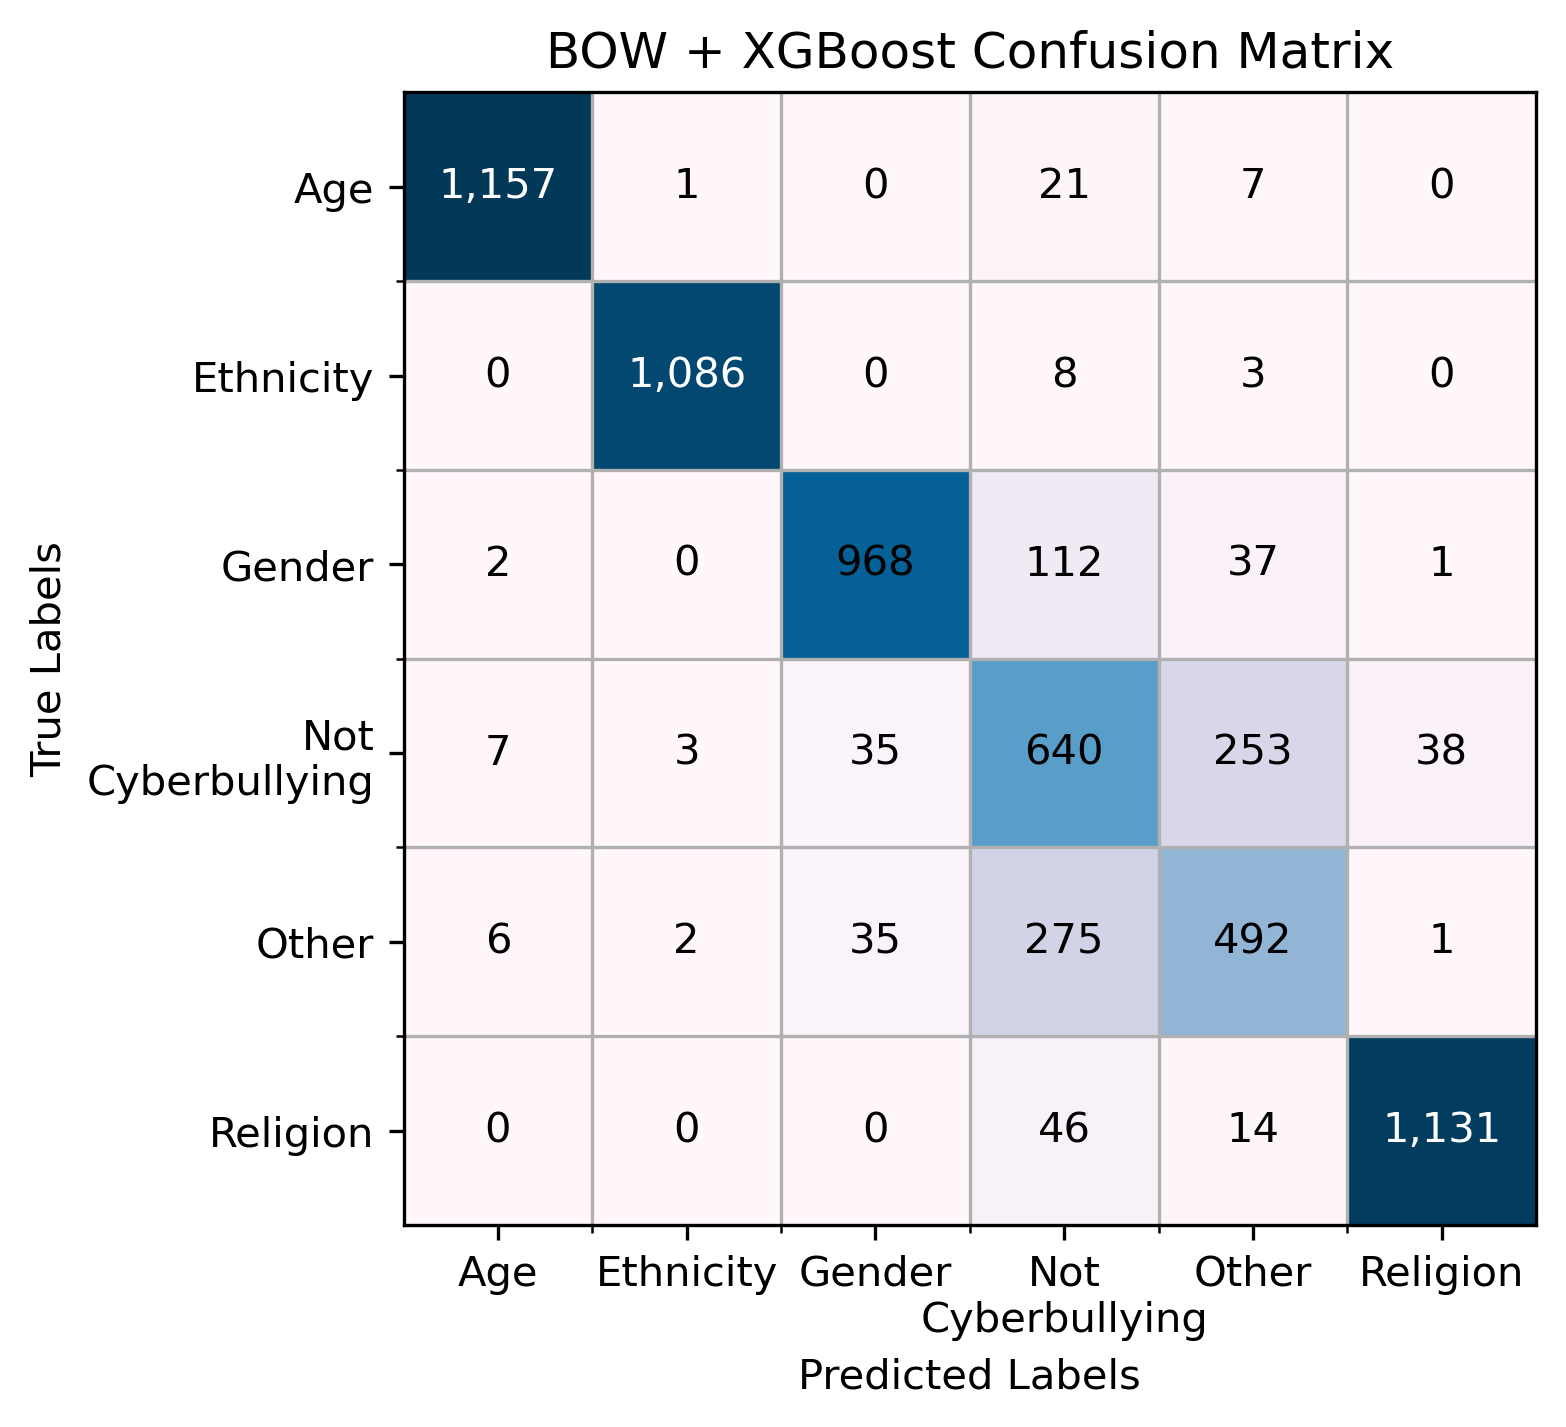

In [49]:
plt.rcParams["figure.figsize"] = [5,5]
plt.rcParams["figure.dpi"] = 300

fig, ax = plt.subplots()
conf_mat = confusion_matrix(y_test, y_pred_xgb_bow)

ax.matshow(conf_mat, cmap = "PuBu")

labels = ["Age", "Ethnicity", "Gender", "Not\nCyberbullying", "Other",  "Religion",]

ax.set_yticks(np.arange(6), labels)
ax.set_xticks(np.arange(6), labels)

#set minor ticks for grid seperation
ax.set_xticks(np.arange(0.5, 5.5, 1), minor=True)
ax.set_yticks(np.arange(0.5, 5.5, 1), minor=True)

ax.xaxis.set_ticks_position("bottom")

#add in labels for numbers 
for (i, j), z in np.ndenumerate(conf_mat):
    if z > 1000: 
        ax.text(j, i, '{:,}'.format(z), ha='center', va='center', color = "white")
    else: 
        ax.text(j, i, '{:,}'.format(z), ha='center', va='center')

ax.grid(which="minor")
ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")
ax.set_title("BOW + XGBoost Confusion Matrix")

plt.savefig("../../plots/xgb_confmat.png", bbox_inches = "tight")

# Probability Averaging Ensemble 

While the three models have similar accuracy they may perform differently class by class. With the probability averaging ensemble the three model probabilties per class are averaged before a classification is chosen. 

In [39]:
#retrain svms to enable probability
svm_bow = SVC(max_iter = 10000, C = 0.13422383454969025, probability = True,
                kernel = "linear").fit(X_train_bow, y_train)

svm_tfidf = SVC(max_iter = 10000, C = 0.9384186373383406, probability = True,
                kernel = "linear").fit(X_train_tfidf, y_train)

In [82]:
#bow ensemble 
avg_probs_bow = np.mean(np.array([
        log_reg_bow.predict_proba(X_test_bow),
        xgb_bow.predict(D_test_bow),
        svm_bow.predict_proba(X_test_bow)]), axis = 0)

y_pred_ens_bow = np.argmax(avg_probs_bow, axis = 1)

#tfidf ensemble
avg_probs_tfidf = np.mean(np.array([
        log_reg_tfidf.predict_proba(X_test_tfidf),
        xgb_tfidf.predict(D_test_tfidf),
        svm_tfidf.predict_proba(X_test_tfidf)]), axis = 0)

y_pred_ens_tfidf = np.argmax(avg_probs_tfidf, axis = 1)

In [83]:
print("BOW Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_ens_bow)}")
print(classification_report(y_test, y_pred_ens_bow), "\n")


print("TFIDF Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_ens_tfidf)}")
print(classification_report(y_test, y_pred_ens_tfidf), "\n")

BOW Embedding Classification Report
Model Accuracy: 0.8623927472883277
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       899
           1       0.92      0.88      0.90      1083
           2       0.95      0.95      0.95      1183
           3       0.63      0.61      0.62       744
           4       0.98      0.97      0.97      1177
           5       0.99      0.98      0.98      1091

    accuracy                           0.86      6177
   macro avg       0.84      0.84      0.84      6177
weighted avg       0.87      0.86      0.86      6177
 

TFIDF Embedding Classification Report
Model Accuracy: 0.861583292860612
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       899
           1       0.91      0.88      0.89      1083
           2       0.95      0.96      0.95      1183
           3       0.63      0.62      0.62       744
           4       0.96      0.97      0.

In [93]:
models = ["BOW+LR", "BOW+SVM", "BOW+XGB", 
          "TF-IDF+LR", "TF-IDF+SVM", "TF-IDF+XGB"]
predictions = [y_pred_lr_bow, y_pred_svm_bow, y_pred_xgb_bow, 
               y_pred_lr_tfidf, y_pred_svm_tfidf, y_pred_xgb_tfidf]

for model, y_hat in zip(models, predictions): 
    print(model)
    f1_macro = f1(y_test, y_hat, average="macro")
    print(f"f1:\t{f1_macro:0.4f}", f"accuracy:\t{accuracy(y_test, y_hat):0.4f}\n")


BOW+LR
f1:	0.8313 accuracy:	0.8527

BOW+SVM
f1:	0.8345 accuracy:	0.8540

BOW+XGB
f1:	0.8454 accuracy:	0.8645

TF-IDF+LR
f1:	0.8242 accuracy:	0.8473

TF-IDF+SVM
f1:	0.8361 accuracy:	0.8575

TF-IDF+XGB
f1:	0.8360 accuracy:	0.8559

